In [1]:
import os
import numpy as np
import gzip
import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

def gencode_v12(filepath, feature = 'gene', trim=False, biotype=['protein_coding'], include_chrom = 0, include_chroms=['{:d}'.format(x + 1) for x in range(22)]):
    annotfile = os.path.realpath(filepath)
    geneinfo = list()
    try:
        with gzip.open(annotfile, 'r') as mfile:
            for line in mfile:
                linesplit = line.decode().strip().split('\t')
                if linesplit[0][0] == '#' or linesplit[2] != feature: continue # skip header

                chrom = linesplit[0][3:]
                if include_chrom > 0:
                    include_chroms = ['{:d}'.format(include_chrom)]
                if chrom not in include_chroms: continue

                # Any particular biotype selected?
                infolist = linesplit[8].split(';')
                if len(biotype) > 0:
                    rowtype = infolist[2].strip().split(' ')[1].replace('"','')
                    if rowtype not in biotype: continue

                # TSS: gene start (0-based coordinates for BED)
                if linesplit[6] == '+':
                    start = np.int64(linesplit[3]) - 1
                    end   = np.int64(linesplit[4])
                elif linesplit[6] == '-':
                    start = np.int64(linesplit[3])  # last base of gene
                    end   = np.int64(linesplit[4]) - 1
                else:
                    raise ValueError('Strand not specified.')

                # For simulation
                if linesplit[1] == 'SIMULATION':
                    start = np.int64(linesplit[3])
                    end   = np.int64(linesplit[4])

                gene_id = infolist[0].strip().split(' ')[1].replace('"','')
                if trim:
                    gene_id = gene_id.split(".")[0]
                gene_name = infolist[4].strip().split(' ')[1].replace('"','')
                this_gene = GeneInfo(name       = gene_name,
                                     ensembl_id = gene_id,
                                     chrom      = int(chrom),
                                     start      = start,
                                     end        = end)

                geneinfo.append(this_gene)
    except IOError as err:
        raise IOError('{:s}: {:s}'.format(annotfile, err.strerror))

    return geneinfo

In [3]:
base_dir = "/cbscratch/franco/datasets"
gtffile = os.path.join(base_dir, "gtex/gencode.v19.annotation.gtf.gz")
genemapfile = os.path.join(base_dir, "crossmappability/hg19_gencode19_75merExon_36merUTR_2mismatch_gene_mappability.txt.gz")
crossmapfile = os.path.join(base_dir, "crossmappability/hg19_gencode19_75merExon_36merUTR_2mismatch_cross_mappability.txt.gz")

In [4]:
gene_info = gencode_v12(gtffile, trim=False)

In [26]:
def read_crossmap(crossmapfile):
    gene_ids = collections.defaultdict(lambda: False)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_ids[arr[0].decode('utf-8')] = True
            gene_ids[arr[1].decode('utf-8')] = True
    return gene_ids

cross_gene_ids = read_crossmap(crossmapfile)            

In [35]:
def read_genemapp(genemapfile):
    gene_mapp = collections.defaultdict(lambda: False)
    with gzip.open(genemapfile, 'r') as instream:
        for line in instream:
            gene_id, mapp = line.rstrip().split()
            if mapp != b'NA':
                gene_mapp[gene_id.decode('utf-8')] = float(mapp)
    return gene_mapp

gene_mapp = read_genemapp(genemapfile)

In [32]:
good_cross_genes = list()
counter = 0
for g in gene_info:
    if not cross_gene_ids[g.ensembl_id]:
        good_cross_genes.append(g.ensembl_id)
    else:
        counter += 1
print("Discarded ",counter,"genes, only", len(good_cross_genes), "remain")

Discarded  12415 genes


In [39]:
good_gene_mapp = list()
for g in gene_info:
    if gene_mapp[g.ensembl_id] and gene_mapp[g.ensembl_id] >= 0.8:
        if not cross_gene_ids[g.ensembl_id]:
            good_gene_mapp.append(g.ensembl_id)
print(len(good_gene_mapp))

6913


In [41]:
with open("non_crossmap_genes.txt", 'w') as outstream:
    for g in good_gene_mapp:
        outstream.write(g+"\n")

In [103]:
import pandas as pd
# gxfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/lmcorrected/ms_age_lmcorrected.txt.gencode_filtered"
gxfile = "/cbscratch/franco/trans-eqtl/preprocess/gtex/expression/lmcorrected/ms_lmcorrected.txt.gencode_filtered"

expr_df = pd.read_csv(gxfile, header=0, sep="\t", index_col=0)

In [104]:
expr_df.head()

,GTEX-P4PP,GTEX-SNOS,GTEX-PW2O,GTEX-RU72,GTEX-U3ZH,GTEX-PLZ4,GTEX-WOFL,GTEX-R55D,GTEX-Q2AG,GTEX-QDT8,...,GTEX-139T8,GTEX-13FH7,GTEX-YF7O,GTEX-11TTK,GTEX-Y3IK,GTEX-YEC3,GTEX-11ONC,GTEX-ZZPT,GTEX-ZVTK,GTEX-XBEC
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000237683.5,-0.597753,0.233754,0.291836,-0.857528,-0.630497,0.881766,1.004344,-0.103786,-0.633435,-0.633051,...,0.122772,-0.360906,0.490602,-1.494378,-0.093524,-0.695693,-0.314581,0.001704,-0.471035,0.261044
ENSG00000187634.6,-0.071724,-1.865905,-0.035175,-0.258311,-1.152482,-0.983320,-0.020053,-0.078396,0.971627,0.049531,...,-1.038728,-0.458834,-0.029502,-1.186068,-1.226412,0.144836,-0.783816,-0.610025,-0.967914,0.259983
ENSG00000188976.6,2.202888,0.824060,0.544913,0.323927,1.587304,1.478509,0.361334,1.070309,-0.851450,0.182099,...,1.171302,0.353094,1.696849,-0.354579,0.523577,0.023943,0.316319,1.346614,-0.846325,-0.774932
ENSG00000187961.9,2.105193,1.263074,0.363695,0.733010,-0.275304,0.790844,1.727083,0.039136,0.330289,-0.886084,...,2.009995,-0.427792,0.660678,-1.442781,-2.573787,-0.904839,-0.787884,2.153558,0.165084,-0.775429
ENSG00000187583.6,-0.555998,0.381398,0.001875,-0.418035,-2.345332,-0.116200,-1.103694,-0.733140,-0.670420,0.081721,...,-0.571852,-1.097629,-1.347004,-1.292339,-0.476408,-0.405794,-0.053295,-1.776364,1.206002,1.475219


In [105]:
curr_index = expr_df.index
genelist = list()
for g in good_gene_mapp:
    if g in curr_index:
        genelist.append(g)
        
new_expr = expr_df.loc[genelist]

In [106]:
outfile = gxfile+".crossmap_filtered"
if not os.path.exists(outfile):
    new_expr.to_csv(outfile, doublequote=False, sep="\t")

6
7
8


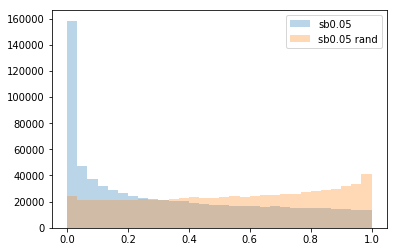

In [112]:
import pandas as pd
import matplotlib.pyplot as plt

chrms = [6, 7, 8]
pvallist1 = list()
pvallist2 = list()
for chrom in chrms:
    print(chrom)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/norm/gtex-ms/tejaas/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist1 += list(df.P)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/norm/gtex-ms/tejaas_rand/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist2 += list(df.P)

plt.hist(pvallist1, bins = 30, alpha=0.3, label="sb0.05")
plt.hist(pvallist2, bins = 30, alpha=0.3, label="sb0.05 rand")
# plt.ylim(0, 100000)
plt.legend()
plt.show()

6
7
8


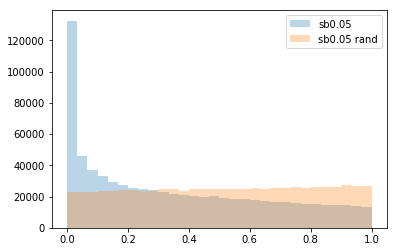

In [111]:
import pandas as pd

chrms = [6, 7, 8]
pvallist1 = list()
pvallist2 = list()
for chrom in chrms:
    print(chrom)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/norm_crossmap/gtex-ms/tejaas/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist1 += list(df.P)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/norm_crossmap/gtex-ms/tejaas_rand/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist2 += list(df.P)

    
plt.hist(pvallist1, bins = 30, alpha=0.3, label="sb0.05")
plt.hist(pvallist2, bins = 30, alpha=0.3, label="sb0.05 rand")
# plt.ylim(0, 150000)
plt.legend()
plt.show()

6
7
8


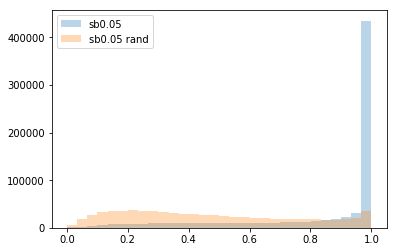

In [113]:
import pandas as pd

chrms = [6, 7, 8]
pvallist1 = list()
pvallist2 = list()
for chrom in chrms:
    print(chrom)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/lm_crossmap/gtex-ms/tejaas/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist1 += list(df.P)
    inputfile = "/cbscratch/franco/trans-eqtl/dev-pipeline/lm_crossmap/gtex-ms/tejaas_rand/permnull_sb0.05/chr"+str(chrom)+"/rr.txt"
    df = pd.read_table(inputfile, header=0)
    pvallist2 += list(df.P)

    
plt.hist(pvallist1, bins = 30, alpha=0.3, label="sb0.05")
plt.hist(pvallist2, bins = 30, alpha=0.3, label="sb0.05 rand")
# plt.ylim(0, 150000)
plt.legend()
plt.show()

In [85]:
from statsmodels.stats import multitest
reject, bhlist, _a, _b = multitest.multipletests(np.array(pvallist2), method="fdr_bh")

In [86]:
np.array(pvallist1)[(bhlist < 0.05)]

array([], dtype=float64)